# Wild Edible Plants Classifier

In [1]:
# Install libraries from requirements.txt if required
# pip install -r requirements.txt

In [2]:
import numpy as np

from functions.model import Classifier
from functions.plotting import Plotter
from functions.utils import Utilities

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models

%matplotlib inline

# 1. Data Preparation

## 1.1 Visualize Plant Classes

In [3]:
# Load sample of data with basic transforms
sample_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(400),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
sample = torchvision.datasets.ImageFolder('dataset/sample',
                                          transform=sample_transform) # Desktop
print(sample)

Dataset ImageFolder
    Number of datapoints: 35
    Root location: D:/Projects/Uni Work/Year 3/flickr_data/sample
    StandardTransform
Transform: Compose(
               Resize(size=400, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(400, 400))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


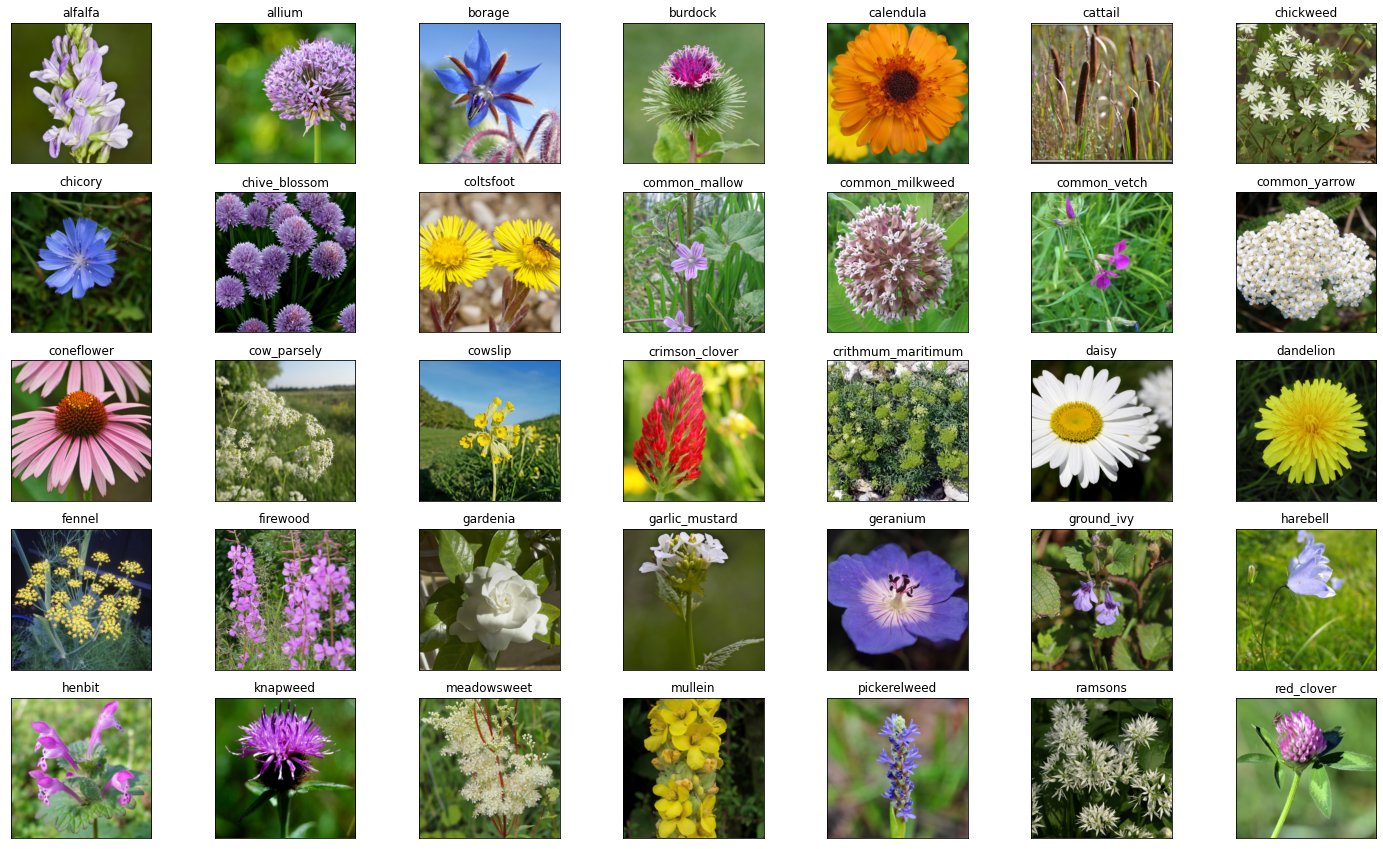

In [4]:
# Create global class labels
labels = np.array(list(sample.class_to_idx), dtype=object)

# Set Plotter and Helper class objects
vis = Plotter(labels)
utils = Utilities()

# Obtain the batch of images (full sample)
sample_loader = torch.utils.data.DataLoader(sample, batch_size=labels.size)
sample_iter = iter(sample_loader)
s_img, s_label = sample_iter.next()
s_img = s_img.numpy() # Convert to numpy so can display

# Visualize each class
vis.visualize_imgs(s_img, s_label)

# Save plot
# fig.savefig("class_sample.png")

# 2. Data Segregation

## 2.1 Data Augmentation

In [5]:
# Set transformations for batch data
transform = transforms.Compose([
    transforms.Resize(224), # Resize images to 224
    transforms.CenterCrop(224), # Make images 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip some samples (50% chance)
    transforms.RandomRotation(20), # Randomly rotate some samples
    transforms.ToTensor(), # Convert image to a tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Normalize image values
])

# Get the data
dataset = torchvision.datasets.ImageFolder('dataset/resized',
                                              transform=transform) # Desktop
print(dataset)

Dataset ImageFolder
    Number of datapoints: 16526
    Root location: D:/Projects/Uni Work/Year 3/flickr_data/resized
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## 2.2 Split the Data

In [6]:
# Set seed to recreate results
np.random.seed(1)

# Set core DataLoader parameters
batch_size = 64 # samples per batch to load
split_size = 0.15 # validation & test dataset size

# Split data
train_loader, valid_loader, test_loader = utils.split_data(dataset, batch_size, split_size)

## 2.3 Visualize a Batch of Training Data

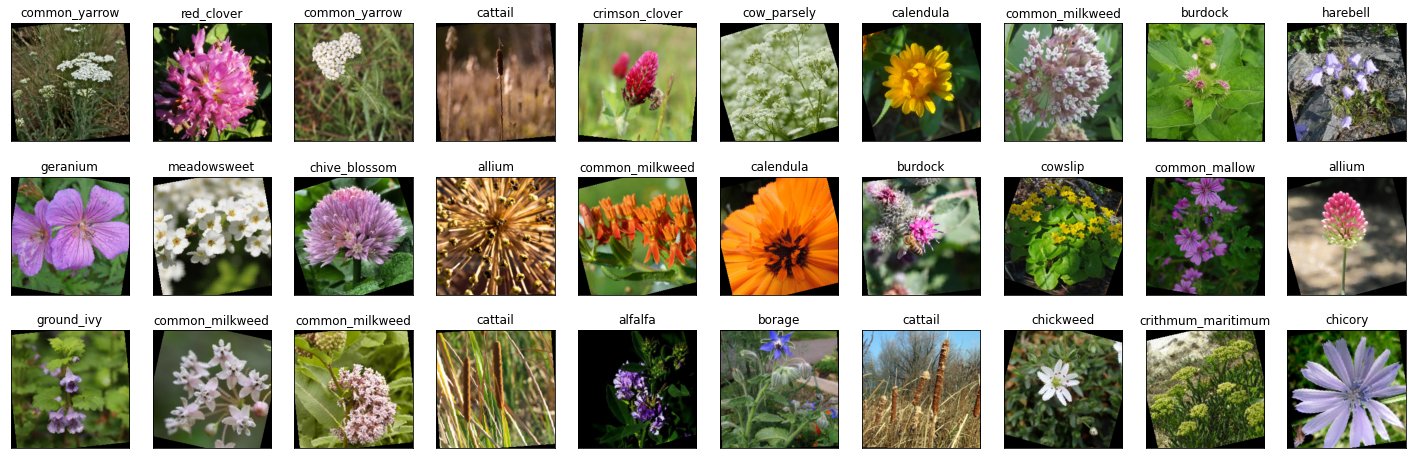

In [7]:
# Obtain the batch of images
train_iter = iter(train_loader)
imgs, lbls = train_iter.next()
imgs = imgs.numpy() # Convert to numpy so can display

# Visualize each class
vis.visualize_imgs(imgs, lbls, figsize=(25, 8), num_rows=3, num_cols=30)

# 3. Model Training

## 3.1 Create CNN Architectures
As the dataset used is small and contains similarities to the ImageNet database, the model itself can be reused. The only adjustment that needs to be made is to add one or two new fully-connected layers to be trained on the wild edible plant dataset.

In [8]:
# Create instances of pretrained CNN architectures
googlenet = models.googlenet(pretrained=True)
mobilenetv2 = models.mobilenet_v2(pretrained=True)
resnet34 = models.resnet34(pretrained=True)

Next it is important to check the layers of the architectures to understand the naming of the ending layers. Taking those names we can then add in the new layers for training the dataset.

In [9]:
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
mobilenetv2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Set hidden layers
h_layers = [512, 256]

# Initialize new classifiers
gnet_classifier = Classifier(in_features=googlenet.fc.in_features, out_features=35, 
                             hidden_layers=h_layers)
mobilenet_classifier = Classifier(in_features=mobilenetv2.classifier[1].in_features, 
                                  out_features=35, hidden_layers=h_layers)
resnet_classifier = Classifier(in_features=resnet34.fc.in_features, out_features=35, 
                               hidden_layers=h_layers)
print("GoogLeNet",gnet_classifier)
print("\nMobileNet",mobilenet_classifier)
print("\nResNet",resnet_classifier)

GoogLeNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

MobileNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

ResNet Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=35, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## 3.2 Update CNN Architectures

In [13]:
# Freeze architecture parameters to avoid backpropagating them (replacing pretrained weights)
models = [googlenet, mobilenetv2, resnet34]
for model in models:
    for param in model.parameters():
        param.requires_grad = False

In [14]:
# Replace last FC layer for GoogLeNet with new classifier
googlenet.fc = gnet_classifier
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
# Replace classifier with new one
mobilenetv2.classifier = mobilenet_classifier
mobilenetv2

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [16]:
resnet34.fc = resnet_classifier
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# Total params for each model
model_names = ["GoogleNet", "MobileNet v2", "ResNet-34"]
for idx, model in enumerate(models):
    print(f"{model_names[idx]}:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters')
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} training parameters\n')

GoogleNet:
6,265,027 total parameters
665,123 training parameters

MobileNet v2:
3,020,067 total parameters
796,195 training parameters

ResNet-34:
21,687,651 total parameters
402,979 training parameters



## 3.3 Initial Training of CNN Models

In [18]:
# Set to GPU if available
device = utils.set_device()

CUDA is available. Device has been set to GPU.


In [19]:
# Set hyperparameters
epochs = 20
learning_rate = 0.001

In [20]:
# Train GoogLeNet
# Reminder: only target classifier parameters (rest are frozen)
googlenet.to(device) # move to GPU
filepath = "saved_models/googlenet_model.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=learning_rate)

utils.train(googlenet, train_loader, valid_loader, criterion, 
            optimizer, filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.889 Validation Loss: 1.940 Accuracy: 0.457
Validation loss decreased (inf -> 1.940). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.786 Validation Loss: 1.313 Accuracy: 0.626
Validation loss decreased (1.940 -> 1.313). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.449 Validation Loss: 1.166 Accuracy: 0.673
Validation loss decreased (1.313 -> 1.166). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 1.331 Validation Loss: 1.020 Accuracy: 0.699
Validation loss decreased (1.166 -> 1.020). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 1.192 Validation Loss: 0.983 Accuracy: 0.711
Validation loss decreased (1.020 -> 0.983). Saving model...
Epoch: 3/20 Step: 180/180 Training Loss: 1.174 Validation Loss: 0.938 Accuracy: 0.727
Validation loss decreased (0.983 -> 0.938). Saving model...
Epoch: 4/20 Step: 90/180 Training Loss: 1.102 Validation Loss: 0.871 Accuracy: 0.745
Validation loss decreased (0.938 -> 0.871). 

In [21]:
# Train MobileNet V2
# Reminder: only target classifier parameters (rest are frozen)
mobilenetv2.to(device) # move to GPU
filepath = "saved_models/mobilenetv2_model.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(mobilenetv2.classifier.parameters(), lr=learning_rate)

utils.train(mobilenetv2, train_loader, valid_loader, criterion, 
            optimizer, filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.466 Validation Loss: 1.361 Accuracy: 0.610
Validation loss decreased (inf -> 1.361). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.327 Validation Loss: 0.956 Accuracy: 0.729
Validation loss decreased (1.361 -> 0.956). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.063 Validation Loss: 0.830 Accuracy: 0.773
Validation loss decreased (0.956 -> 0.830). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 0.952 Validation Loss: 0.679 Accuracy: 0.803
Validation loss decreased (0.830 -> 0.679). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 0.826 Validation Loss: 0.702 Accuracy: 0.798
Early stopping counter: 1/5.
Epoch: 3/20 Step: 180/180 Training Loss: 0.835 Validation Loss: 0.664 Accuracy: 0.811
Validation loss decreased (0.679 -> 0.664). Saving model...
Epoch: 4/20 Step: 90/180 Training Loss: 0.761 Validation Loss: 0.629 Accuracy: 0.816
Validation loss decreased (0.664 -> 0.629). Saving model...
Epoch: 4/20 Ste

In [22]:
# Train ResNet-34
# Reminder: only target classifier parameters (rest are frozen)
resnet34.to(device) # move to GPU
filepath = "saved_models/resnet34_model.pt"

# Set loss function and optimizer
criterion = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = torch.optim.Adam(resnet34.fc.parameters(), lr=learning_rate)

utils.train(resnet34, train_loader, valid_loader, criterion, 
            optimizer, filepath, epochs)

Epoch: 1/20 Step: 90/180 Training Loss: 2.655 Validation Loss: 1.512 Accuracy: 0.596
Validation loss decreased (inf -> 1.512). Saving model...
Epoch: 1/20 Step: 180/180 Training Loss: 1.527 Validation Loss: 1.086 Accuracy: 0.691
Validation loss decreased (1.512 -> 1.086). Saving model...
Epoch: 2/20 Step: 90/180 Training Loss: 1.183 Validation Loss: 0.927 Accuracy: 0.722
Validation loss decreased (1.086 -> 0.927). Saving model...
Epoch: 2/20 Step: 180/180 Training Loss: 1.077 Validation Loss: 0.846 Accuracy: 0.755
Validation loss decreased (0.927 -> 0.846). Saving model...
Epoch: 3/20 Step: 90/180 Training Loss: 1.005 Validation Loss: 0.772 Accuracy: 0.780
Validation loss decreased (0.846 -> 0.772). Saving model...
Epoch: 3/20 Step: 180/180 Training Loss: 0.948 Validation Loss: 0.741 Accuracy: 0.780
Validation loss decreased (0.772 -> 0.741). Saving model...
Epoch: 4/20 Step: 90/180 Training Loss: 0.904 Validation Loss: 0.753 Accuracy: 0.773
Early stopping counter: 1/5.
Epoch: 4/20 Ste

# 4. Performance Evaluation

In [ ]:
# Plot loss comparsion
vis.create_plots(models, model_names, figsize=(15, 4), plot_func=vis.plot_losses,
                 plot_name="valid_model_losses", save=True)

In [ ]:
for i in range(len(models)):
    # Calculate predictions and loader labels
    y_pred, y_true = utils.predict(models[i], valid_loader)

    # Convert indices to string labels for plotting
    y_pred, y_true = utils.indices_to_labels(y_pred, y_true, labels)

    # Plot confusion matrices
    vis.plot_cm(models[i], model_names[i], y_pred, y_true)

# 5. Hyperparameter Tuning
Please refer to the Jupyter Notebook `2. wep_classifier_tuning.ipynb` for this section.